# Pair Trading of GLD and GDX

GLD versus GDX is a good candidate for pair trading because GLD reflects the spot price of gold, and GDX is a basket of gold-mining stocks. It makes intuitive sense that their prices should move in tandem. (see, e.g., Chan, 2006b)



We will perform a regression analysis on the training set to determine the hedge ratio between GLD and GDX, and then define entry and exit thresholds for a pair-trading strategy. We will see how optimizing these thresholds on the training set changes the performance on the test set.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf

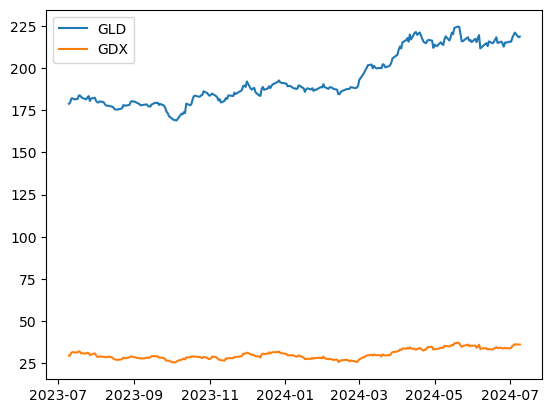

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2023-07-10 00:00:00-04:00,178.369995,178.919998,178.259995,178.779999,3320500,0.0,0.0,0.0
2023-07-11 00:00:00-04:00,179.429993,179.710007,179.130005,179.449997,2819600,0.0,0.0,0.0


In [2]:
# load GLD and GDX historic data (1 yr, daily)
gld = yf.Ticker("GLD")
gdx = yf.Ticker("GDX")
# gld.info
df_gld = gld.history(period="1y")
df_gdx = gdx.history(period="1y")
# merge df
df = pd.merge(df_gld['Close'], df_gdx['Close'], on='Date', suffixes=('_GLD', '_GDX'))

# plot price movements
plt.plot(df['Close_GLD'], label='GLD')
plt.plot(df['Close_GDX'], label='GDX')
plt.legend()
plt.show()

df_gld.head(2)

Pearson correlation coefficient: 0.8825857512287222


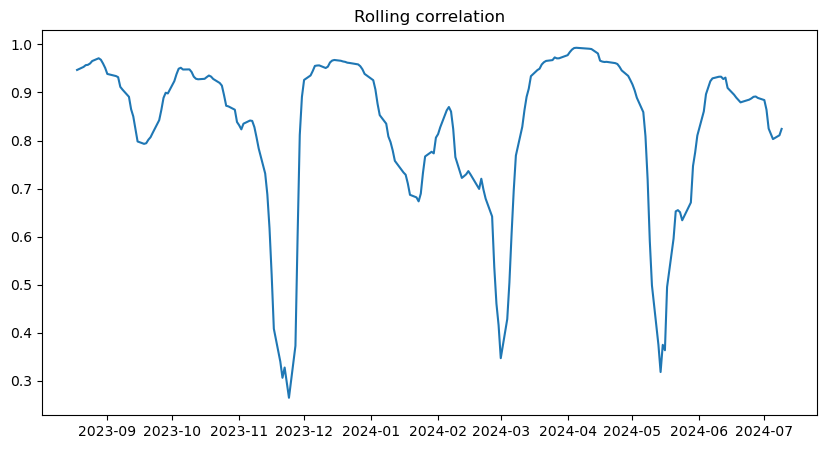

In [3]:
## correlation analysis

# compute Pearson correlation coefficient
from scipy.stats import pearsonr
print('Pearson correlation coefficient:', pearsonr(df['Close_GLD'], df['Close_GDX'])[0])

# compute rolling correlation
rolling_corr = df['Close_GLD'].rolling(window=30).corr(df['Close_GDX'])
plt.figure(figsize=(10, 5))
plt.plot(rolling_corr)
plt.title('Rolling correlation')
plt.show()

Hedge ratio: Close_GDX    6.42086
dtype: float64


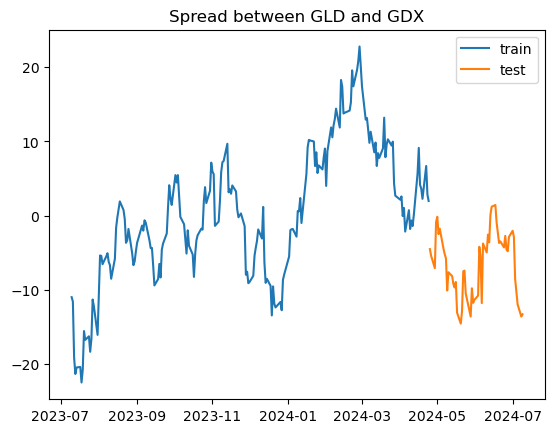

Spread mean: 0.2867516740721787
Spread std: 9.046059500912817
Sharpe ratio (train): 1.4302951400272572


In [4]:
# split data into training and testing sets
train_idx = np.arange(0, int(0.8*len(df)))
test_idx = np.arange(int(0.8*len(df)), len(df))

# linear regression
model = sm.OLS(df['Close_GLD'].iloc[train_idx], df['Close_GDX'].iloc[train_idx])
results = model.fit()
hedgeRatio = results.params
print('Hedge ratio:', hedgeRatio)

# spead = GLD - hedgeRatio*GDX
spread = df.loc[:, 'Close_GLD'] - hedgeRatio[0] * df.loc[:, 'Close_GDX']
plt.plot(spread.iloc[train_idx], label='train')
plt.plot(spread.iloc[test_idx], label='test')
plt.title('Spread between GLD and GDX')
plt.legend()
plt.show()

spreadMean = spread.iloc[train_idx].mean()
print('Spread mean:', spreadMean)
spreadStd = spread.iloc[train_idx].std()
print('Spread std:', spreadStd)

# compute z-score
df['zscore'] = (spread - spreadMean) / spreadStd
positions = ['positions_GLD_long', 'positions_GDX_long', 'positions_GLD_short', 'positions_GDX_short']
for position in positions:
    df[position] = 0
df.loc[df.zscore >= 2, ('positions_GLD_short', 'positions_GDX_short')] = [-1, 1]  # short spread
df.loc[df.zscore <= -2, ('positions_GLD_long', 'positions_GDX_long')] = [1, -1]  # buy spread
df.loc[df.zscore <= 1, ('positions_GLD_short', 'positions_GDX_short')] = 0  # exit short spread
df.loc[df.zscore >= -1, ('positions_GLD_long', 'positions_GDX_long')] = 0  # exit long spread
df.fillna(method='ffill', inplace=True)  # ensure existing positions are carried forward unless there is an exit signal

positions_long = df.loc[:, ['positions_GLD_long', 'positions_GDX_long']]
positions_short = df.loc[:, ['positions_GLD_short', 'positions_GDX_short']]
positions = np.array(positions_long) + np.array(positions_short)
positions = pd.DataFrame(positions)

daily_return = df.loc[:, ['Close_GLD', 'Close_GDX']].pct_change()
pnl = (np.array(positions.shift()) * np.array(daily_return)).sum(axis=1)
sharpe_train = np.sqrt(len(pnl)-1) * pnl[train_idx[1:]].mean() / pnl[train_idx[1:]].std()
print('Sharpe ratio (train):', sharpe_train)

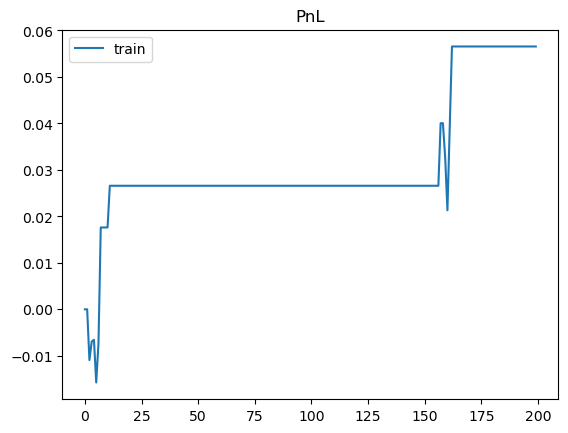

In [5]:
plt.plot(np.cumsum(pnl[train_idx[1:]]), label='train')
plt.legend()
plt.title('PnL')
plt.show()